In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ejlok1/toronto-emotional-speech-set-tess")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/toronto-emotional-speech-set-tess


## Import Modules

In [ ]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio

import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model,Wav2Vec2Processor,Trainer,TrainingArguments,Wav2Vec2ForSequenceClassification
import warnings
warnings.filterwarnings('ignore')

## Load Dataset


In [ ]:
paths =[]
labels = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print('Dataset is loaded')

Dataset is loaded


In [ ]:
len(paths)

2800

In [ ]:
paths[:5]

['/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_home_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_youth_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_near_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_search_fear.wav',
 '/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_pick_fear.wav']

In [ ]:
labels[:5]

['fear', 'fear', 'fear', 'fear', 'fear']

In [ ]:
## Create a dataframe
df = pd.DataFrame()
df['audio_paths'] = paths
df['label'] = labels
df.head()

,audio_paths,label
0,/kaggle/input/toronto-emotional-speech-set-tes...,fear
1,/kaggle/input/toronto-emotional-speech-set-tes...,fear
2,/kaggle/input/toronto-emotional-speech-set-tes...,fear
3,/kaggle/input/toronto-emotional-speech-set-tes...,fear
4,/kaggle/input/toronto-emotional-speech-set-tes...,fear


In [ ]:
df['label'].value_counts()

,count
label,
fear,400
angry,400
disgust,400
neutral,400
sad,400
ps,400
happy,400


## Exploratory Data Analysis

<Axes: xlabel='label', ylabel='count'>

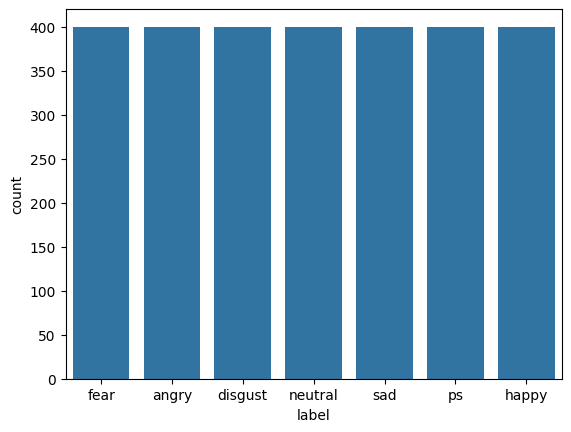

In [ ]:
sns.countplot(x="label", data=df)

In [ ]:
def waveplot(data,sr,emotion):
    plt.figure(figsize=(10, 4))
    plt.title(emotion,size=20)
    librosa.display.waveshow(data,sr=sr)
    plt.show()

def spectogram(data,sr,emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11, 4))
    plt.title(emotion,size=20)
    librosa.display.specshow(xdb,sr=sr,x_axis='time',y_axis='hz')
    plt.colorbar()

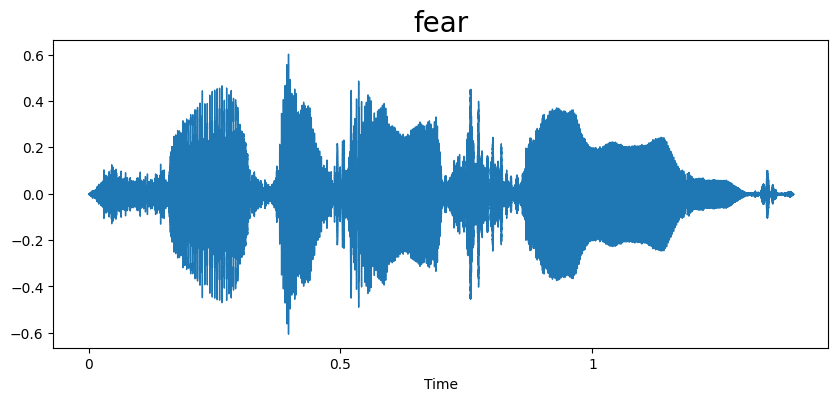

/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_home_fear.wav


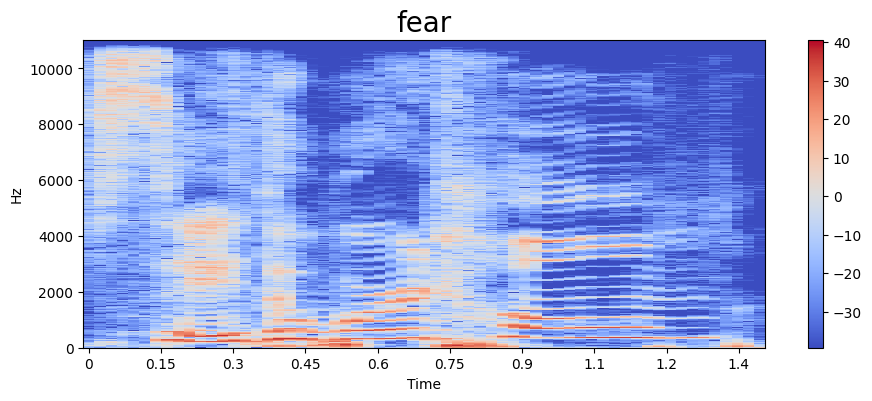

In [ ]:
emotion = 'fear'
path = np.array(df['audio_paths'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data,sampling_rate,emotion)
spectogram(data,sampling_rate,emotion)
Audio(path)
print(path)

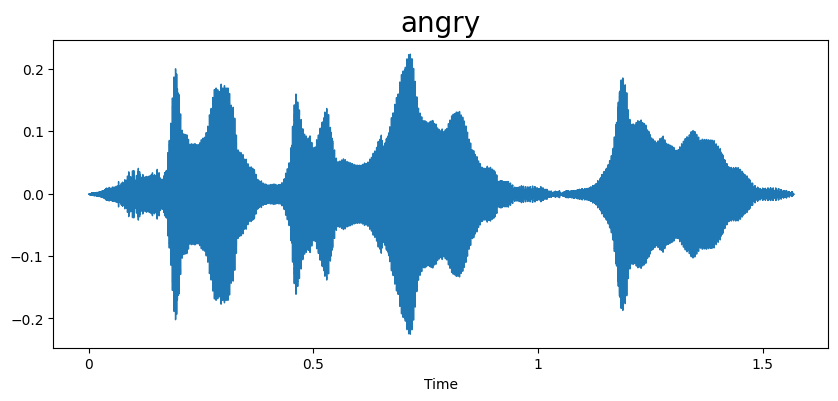

/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_angry/OAF_raid_angry.wav


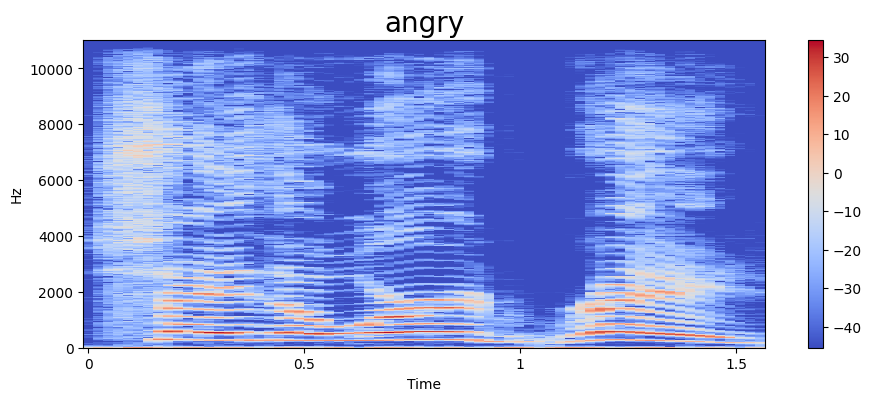

In [ ]:
emotion = 'angry'
path = np.array(df['audio_paths'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data,sampling_rate,emotion)
spectogram(data,sampling_rate,emotion)
Audio(path)
print(path)

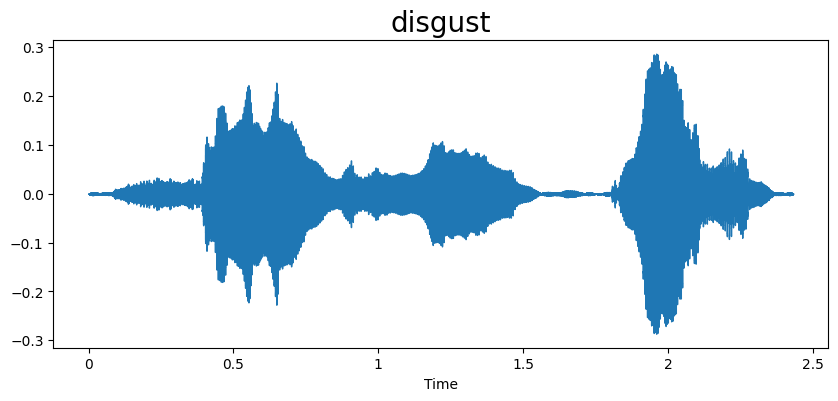

/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_disgust/OAF_good_disgust.wav


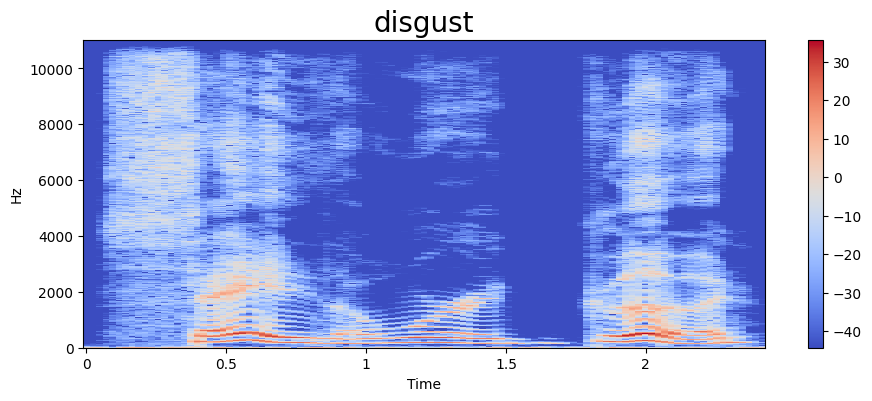

In [ ]:
emotion = 'disgust'
path = np.array(df['audio_paths'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data,sampling_rate,emotion)
spectogram(data,sampling_rate,emotion)
Audio(path)
print(path)

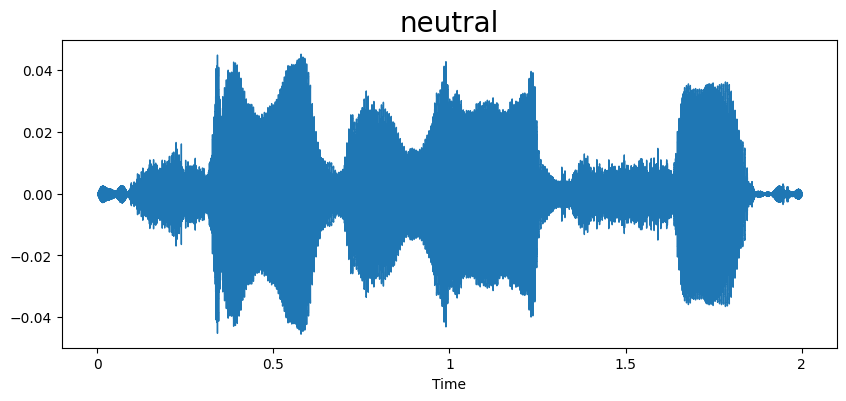

/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_neutral/OAF_soup_neutral.wav


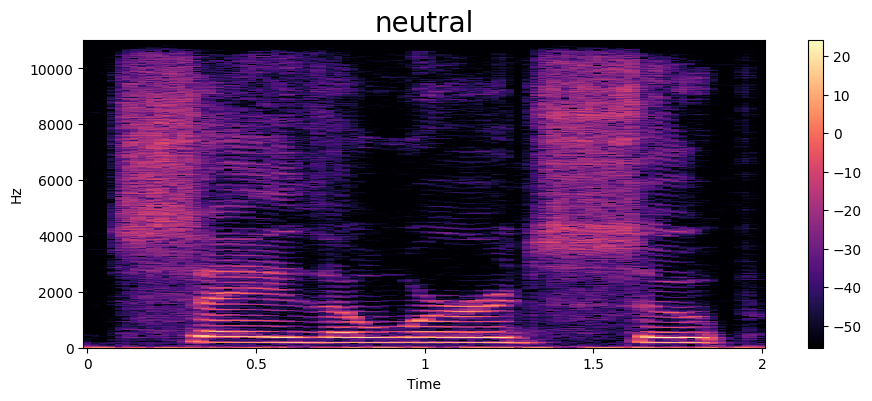

In [ ]:
emotion = 'neutral'
path = np.array(df['audio_paths'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data,sampling_rate,emotion)
spectogram(data,sampling_rate,emotion)
Audio(path)
print(path)

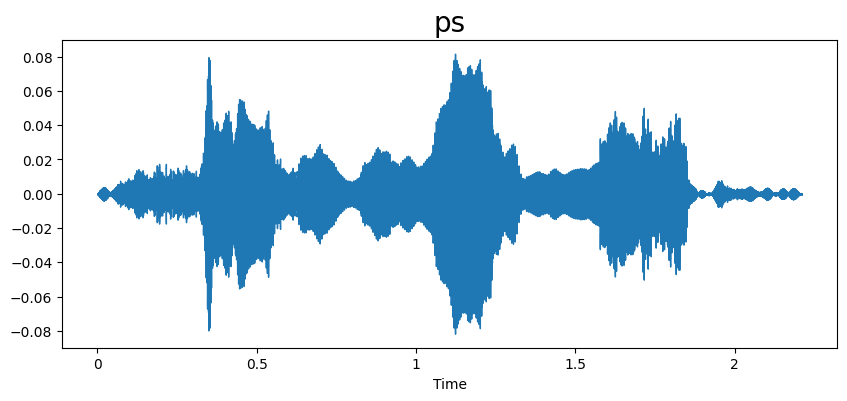

/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_met_ps.wav


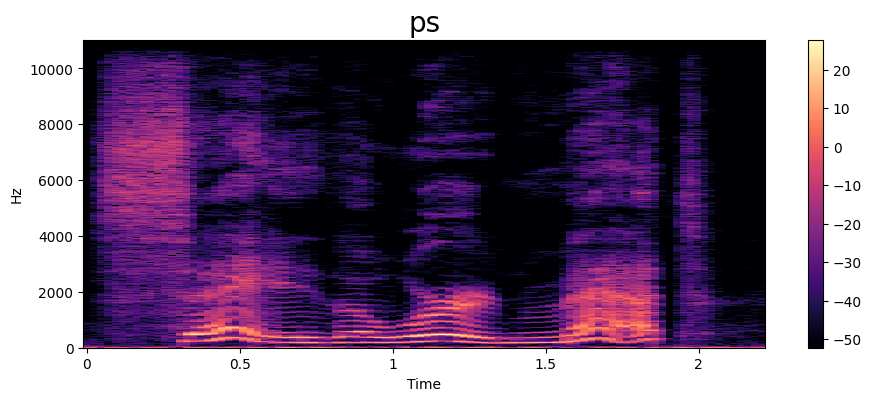

In [ ]:
emotion = 'ps'
path = np.array(df['audio_paths'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data,sampling_rate,emotion)
spectogram(data,sampling_rate,emotion)
Audio(path)
print(path)

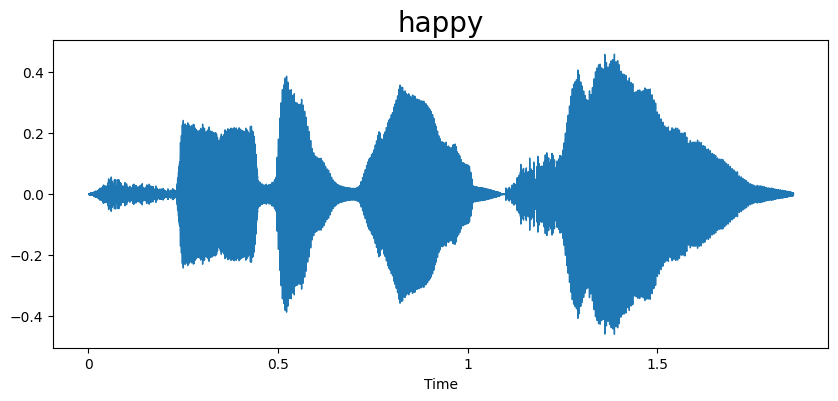

/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_happy/YAF_jail_happy.wav


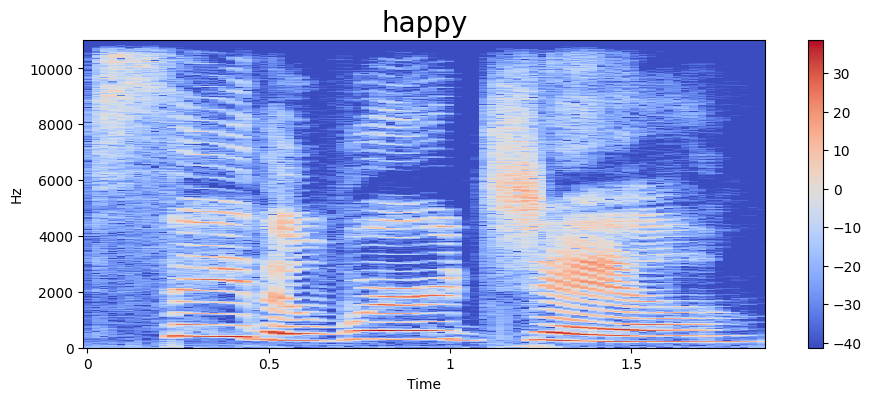

In [ ]:
emotion = 'happy'
path = np.array(df['audio_paths'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data,sampling_rate,emotion)
spectogram(data,sampling_rate,emotion)
Audio(path)
print(path)

## Create Custom Dataset Class



In [ ]:
# covert  labels to integers
label_map = {label:idx for idx, label in enumerate(df['label'].unique())}
inverse_label_map = {idx:label for label, idx in label_map.items()}
df['label'] = df['label'].map(label_map)
df.tail(2)

,audio_paths,label
2798,/kaggle/input/toronto-emotional-speech-set-tes...,5
2799,/kaggle/input/toronto-emotional-speech-set-tes...,5


## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load model & processor

In [ ]:
# 2. Load model + processor
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
import torch, librosa

MODEL = "Dpngtm/wav2vec2-emotion-recognition"
processor = Wav2Vec2Processor.from_pretrained(MODEL)
model = Wav2Vec2ForSequenceClassification.from_pretrained(MODEL)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
emotion_labels = [
    "angry",
    "calm",
    "disgust",
    "fearful",
    "happy",
    "neutral",
    "sad",
    "surprised"
]

In [ ]:
# 3. Test on an audio file (ensure it's 16kHz WAV or let librosa resample)
audio_path = "/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_fear/YAF_home_fear.wav"
speech, sr = librosa.load(audio_path, sr=16000)

inputs = processor(speech, sampling_rate=16000, return_tensors="pt", padding=True)
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    logits = model(**inputs).logits
predicted_id = torch.argmax(logits, dim=-1).item()


emotion = emotion_labels[predicted_id]
print("Predicted emotion:", emotion)

Predicted emotion: fearful


In [ ]:
audio_path = "/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_angry/OAF_raid_angry.wav"
speech, sr = librosa.load(audio_path, sr=16000)

inputs = processor(speech, sampling_rate=16000, return_tensors="pt", padding=True)
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    logits = model(**inputs).logits
predicted_id = torch.argmax(logits, dim=-1).item()


emotion = emotion_labels[predicted_id]
print("Predicted emotion:", emotion)

Predicted emotion: angry


In [ ]:
audio_path = "/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_disgust/OAF_good_disgust.wav"
speech, sr = librosa.load(audio_path, sr=16000)

inputs = processor(speech, sampling_rate=16000, return_tensors="pt", padding=True)
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    logits = model(**inputs).logits
predicted_id = torch.argmax(logits, dim=-1).item()


emotion = emotion_labels[predicted_id]
print("Predicted emotion:", emotion)

Predicted emotion: disgust


In [ ]:
audio_path = "/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_neutral/OAF_soup_neutral.wav"
speech, sr = librosa.load(audio_path, sr=16000)

inputs = processor(speech, sampling_rate=16000, return_tensors="pt", padding=True)
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    logits = model(**inputs).logits
predicted_id = torch.argmax(logits, dim=-1).item()


emotion = emotion_labels[predicted_id]
print("Predicted emotion:", emotion)

Predicted emotion: neutral


In [ ]:
audio_path = "/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/OAF_Pleasant_surprise/OAF_met_ps.wav"
speech, sr = librosa.load(audio_path, sr=16000)

inputs = processor(speech, sampling_rate=16000, return_tensors="pt", padding=True)
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    logits = model(**inputs).logits
predicted_id = torch.argmax(logits, dim=-1).item()


emotion = emotion_labels[predicted_id]
print("Predicted emotion:", emotion)

Predicted emotion: surprised


In [ ]:
audio_path = "/kaggle/input/toronto-emotional-speech-set-tess/TESS Toronto emotional speech set data/YAF_happy/YAF_jail_happy.wav"
speech, sr = librosa.load(audio_path, sr=16000)

inputs = processor(speech, sampling_rate=16000, return_tensors="pt", padding=True)
inputs = {k: v.to(device) for k, v in inputs.items()}

with torch.no_grad():
    logits = model(**inputs).logits
predicted_id = torch.argmax(logits, dim=-1).item()


emotion = emotion_labels[predicted_id]
print("Predicted emotion:", emotion)

Predicted emotion: happy


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Path where you want to save the model in your Drive
save_path = "/content/drive/MyDrive/wav2vec2_emotion_model"

# Save processor + model
processor.save_pretrained(save_path)
model.save_pretrained(save_path)

print("✅ Model saved to:", save_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Model saved to: /content/drive/MyDrive/wav2vec2_emotion_model


In [ ]:
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification

load_path = "/content/drive/MyDrive/wav2vec2_emotion_model"

processor = Wav2Vec2Processor.from_pretrained(load_path)
model = Wav2Vec2ForSequenceClassification.from_pretrained(load_path)
